In [31]:
import jax
import jax.numpy as np
from jax import random
from wasserstein import wasserstein_1d
from jax import grad, jit

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

In [33]:
d = 1
N = 100

key, subkey = random.split(random.PRNGKey(1))
x0 = 3. + 0.5 * random.normal(key, (N, d))
x_plot = np.linspace(-50, 50, 1000)
x_gauss = random.normal(key, (N, d))

In [34]:
h = 1e-6 # must be very small for Cholesky (otherwise NaNs)

def K(x):
    xmx = np.expand_dims(x, 0) - np.expand_dims(x, 1)
    norm = np.einsum('ijk,ijk->ij', xmx, xmx)
    return np.exp(- (norm) / h)

def g_K(x):
    # we avoid calling autograd since the function is non-scalar, for better efficiency
    xmx = np.expand_dims(x, 0) - np.expand_dims(x, 1)
    return np.expand_dims(K(x), -1) * (2. * xmx / h)

def logp(x):
    # Standard Gaussian target
    return -np.sum(x**2)

def p(x):
    return np.exp(-x**2)

### SVGD

In [35]:
def svgd(x0, logp, T=100, eta=0.1):
    
    x = x0
    g_logp = grad(logp)

    update_svgd = jit( lambda x : K(x) @ g_logp(x) + g_K(x).sum(0) ) 

    for i in range(T):
        x = x + eta * update_svgd(x)
        if np.any(np.isnan(x)):
            print(f'NaNs at iteration {i}')
            break
    
    return x

In [8]:
x = svgd(x0, logp, T=1000, eta=0.01)

In [124]:
# plt.plot(x[:,0], x[:,1], 'o')
# plt.axis('equal');

In [171]:
x.mean(), x.std()

(Array(-1.0433197e-05, dtype=float32), Array(1.6938641, dtype=float32))

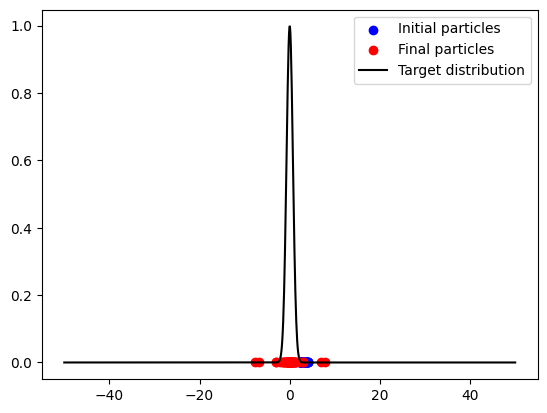

In [172]:
plt.scatter(x0.squeeze(), np.zeros_like(x0.squeeze()), color='blue', label='Initial particles')
plt.scatter(x.squeeze(), np.zeros_like(x.squeeze()), color='red', label='Final particles')
plt.plot(x_plot, p(x_plot), color='black', label='Target distribution')
plt.legend()
plt.show()

In [9]:
# STATISTICAL TESTS

import scipy

# Goodness-of-fit test for initial particles
init_gof = scipy.stats.kstest(x0.squeeze(), p(x_plot).squeeze()) # Kolmogorov-Smirnov test
print(f'Initial goodness-of-fit: {init_gof}')

# Goodness-of-fit test for final particles
final_gof = scipy.stats.kstest(x.squeeze(), p(x_plot).squeeze())
print(f'Final goodness-of-fit: {final_gof}')

Initial goodness-of-fit: KstestResult(statistic=1.0, pvalue=1.4055138003704013e-144, statistic_location=0.9974982, statistic_sign=-1)
Final goodness-of-fit: KstestResult(statistic=0.52, pvalue=3.2716053888834897e-23, statistic_location=-0.022141725, statistic_sign=1)


In [10]:
# GRID SEARCH

Ts = np.array([100, 500, 1000, 5000])
etas = np.array([0.1, 0.05, 0.01, 0.005, 0.001])
grid_x, grid_y = np.meshgrid(Ts, etas)
means = []
stds = []
distances = []

for i in range(grid_x.shape[0]):
    for j in range(grid_y.shape[1]):
        x = svgd(x0, logp, T=grid_x[i, j], eta=grid_y[i, j])
        means.append(x.mean())
        stds.append(x.std())
        distances.append(wasserstein_1d(x.squeeze(), x_gauss.squeeze(), p=1))

means = np.array(means).reshape(grid_x.shape)
stds = np.array(stds).reshape(grid_x.shape)
distances = np.array(distances).reshape(grid_x.shape)

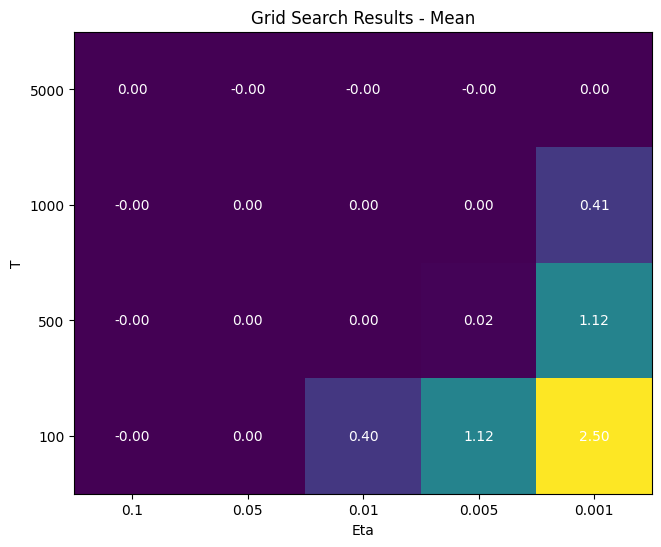

In [18]:
# Plot the grid
plt.figure(figsize=(10, 6))
plt.imshow(means.T, cmap='viridis', origin='lower')

# Add color bar
# cbar = plt.colorbar()
# cbar.set_label('Mean Value')

# Add text annotations for each cell
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        plt.text(i, j, f'{means[i, j]:.2f}', ha='center', va='center', color='white')

# Set x and y axis labels and ticks
plt.xticks(np.arange(grid_x.shape[0]), etas)
plt.yticks(np.arange(grid_x.shape[1]), Ts)
plt.xlabel('Eta')
plt.ylabel('T')

plt.title('Grid Search Results - Mean')
plt.grid(False)
plt.show()

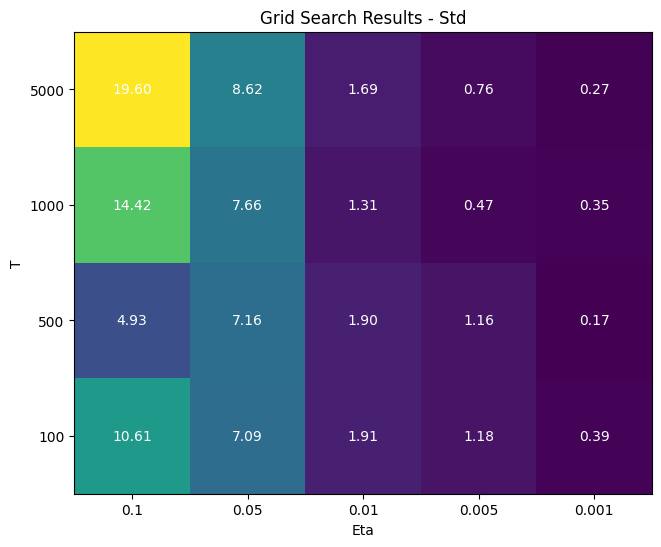

In [19]:
# Plot the grid
plt.figure(figsize=(10, 6))
plt.imshow(stds.T, cmap='viridis', origin='lower')

# Add color bar
# cbar = plt.colorbar()
# cbar.set_label('Standard Deviation')

# Add text annotations for each cell
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        plt.text(i, j, f'{stds[i, j]:.2f}', ha='center', va='center', color='white')

# Set x and y axis labels and ticks
plt.xticks(np.arange(grid_x.shape[0]), etas)
plt.yticks(np.arange(grid_x.shape[1]), Ts)
plt.xlabel('Eta')
plt.ylabel('T')

plt.title('Grid Search Results - Std')
plt.grid(False)
plt.show()

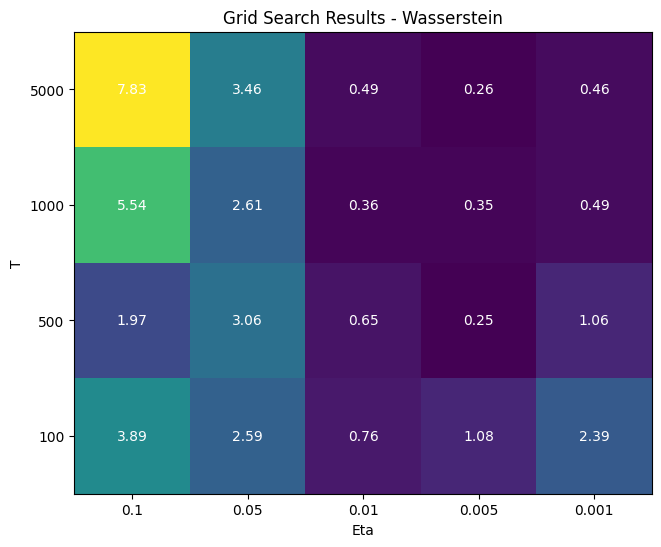

In [20]:
# Plot the grid
plt.figure(figsize=(10, 6))
plt.imshow(distances.T, cmap='viridis', origin='lower')

# Add color bar
# cbar = plt.colorbar()
# cbar.set_label('Wasserstein Distance')

# Add text annotations for each cell
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        plt.text(i, j, f'{distances[i, j]:.2f}', ha='center', va='center', color='white')

# Set x and y axis labels and ticks
plt.xticks(np.arange(grid_x.shape[0]), etas)
plt.yticks(np.arange(grid_x.shape[1]), Ts)
plt.xlabel('Eta')
plt.ylabel('T')

plt.title('Grid Search Results - Wasserstein')
plt.grid(False)
plt.show()

In [21]:
# Check if results are robust

T = 1000
eta = 0.01

means_check = []
stds_check = []
distances_check = []

for i in range(20):
    key, subkey = random.split(random.PRNGKey(1000 * i))
    x0 = 3. + 0.5 * random.normal(key, (N, d))
    x = svgd(x0, logp, T=T, eta=eta)
    means_check.append(x.mean())
    stds_check.append(x.std())
    distances_check.append(wasserstein_1d(x.squeeze(), x_gauss.squeeze(), p=1))

<function matplotlib.pyplot.show(close=None, block=None)>

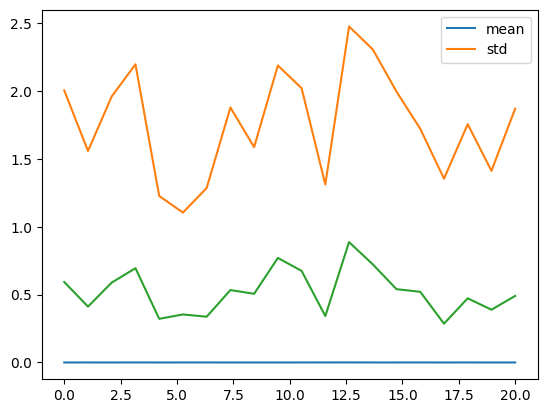

In [23]:
plt.plot(np.linspace(0, 20, 20), np.array(means_check))
plt.plot(np.linspace(0, 20, 20), np.array(stds_check))
plt.plot(np.linspace(0, 20, 20), np.array(distances_check))
plt.legend(['mean', 'std', 'wasserstein'])
plt.show

### SGLD-R

In [36]:
def sgldr(x0, logp, T=100, eta=0.1, key=key):
    
    x = x0
    g_logp = grad(logp)
    xs = []

    update_sgldr = jit( lambda x, key : ( eta * (K(x) @ g_logp(x) + g_K(x).sum(0)) + \
                                         np.linalg.cholesky(2 * eta * K(x)) @ random.normal(key, (N, d)), random.split(key)[0] ) )

    for i in range(T):
        x_upd, key = update_sgldr(x, key)
        x = x + x_upd
        xs.append(x)
        if np.any(np.isnan(x)):
            print(f'NaNs at iteration {i}')
            break
    
    return x, xs

In [25]:
x, xs = sgldr(x0, logp, T=1000, eta=0.01, key=key)

In [82]:
# plt.plot(x[:,0], x[:,1], 'o')
# plt.axis('equal');

In [26]:
x.mean(), x.std()

(Array(-0.04160915, dtype=float32), Array(4.5955257, dtype=float32))

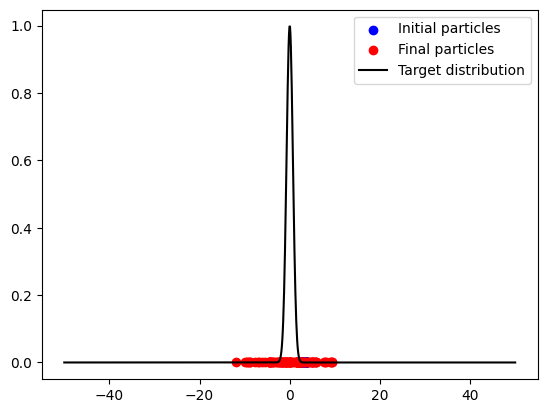

In [27]:
plt.scatter(x0.squeeze(), np.zeros_like(x0.squeeze()), color='blue', label='Initial particles')
plt.scatter(x.squeeze(), np.zeros_like(x.squeeze()), color='red', label='Final particles')
plt.plot(x_plot, p(x_plot), color='black', label='Target distribution')
plt.legend()
plt.show()

In [28]:
# STATISTICAL TESTS

import scipy

# Goodness-of-fit test for initial particles
init_gof = scipy.stats.kstest(x0.squeeze(), p(x_plot).squeeze()) # Kolmogorov-Smirnov test
print(f'Initial goodness-of-fit: {init_gof}')

# Goodness-of-fit test for final particles
final_gof = scipy.stats.kstest(x.squeeze(), p(x_plot).squeeze())
print(f'Final goodness-of-fit: {final_gof}')

Initial goodness-of-fit: KstestResult(statistic=1.0, pvalue=1.4055138003704013e-144, statistic_location=0.9974982, statistic_sign=-1)
Final goodness-of-fit: KstestResult(statistic=0.49, pvalue=1.6472123718765566e-20, statistic_location=-0.118816316, statistic_sign=1)


In [61]:
# GRID SEARCH

Ts = np.array([100, 1000, 10**4, 10**5])
etas = np.array([0.1, 0.01, 0.001, 1e-4, 1e-5, 1e-6])
grid_x, grid_y = np.meshgrid(Ts, etas)
means = []
stds = []
distances = []

for i in range(grid_x.shape[0]):
    for j in range(grid_y.shape[1]):
        x, xs = sgldr(x0, logp, T=grid_x[i, j], eta=grid_y[i, j])
        means.append(x.mean())
        stds.append(x.std())
        if np.any(np.isnan(x)):
            distances.append(-1)
        else:
            distances.append(wasserstein_1d(x.squeeze(), x_gauss.squeeze(), p=1))

means = np.array(means).reshape(grid_x.shape)
stds = np.array(stds).reshape(grid_x.shape)
distances = np.array(distances).reshape(grid_x.shape)

NaNs at iteration 657
NaNs at iteration 657
NaNs at iteration 657
NaNs at iteration 6135
NaNs at iteration 6135
NaNs at iteration 1026
NaNs at iteration 1026
NaNs at iteration 25567
NaNs at iteration 263
NaNs at iteration 263
NaNs at iteration 263
NaNs at iteration 1015
NaNs at iteration 1015


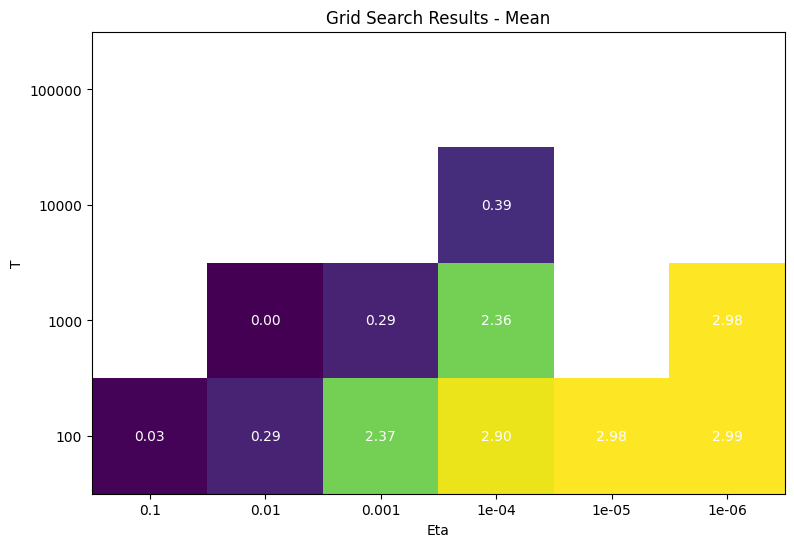

In [62]:
# Plot the grid
plt.figure(figsize=(10, 6))
plt.imshow(means.T, cmap='viridis', origin='lower')

# Add color bar
# cbar = plt.colorbar()
# cbar.set_label('Mean Value')

# Add text annotations for each cell
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        plt.text(i, j, f'{means[i, j]:.2f}', ha='center', va='center', color='white')

# Set x and y axis labels and ticks
plt.xticks(np.arange(grid_x.shape[0]), etas)
plt.yticks(np.arange(grid_x.shape[1]), Ts)
plt.xlabel('Eta')
plt.ylabel('T')

plt.title('Grid Search Results - Mean')
plt.grid(False)
plt.show()

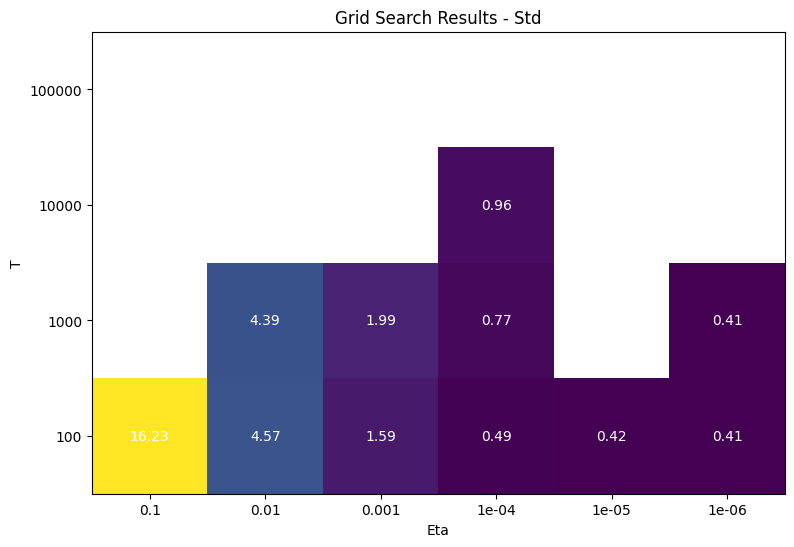

In [63]:
# Plot the grid
plt.figure(figsize=(10, 6))
plt.imshow(stds.T, cmap='viridis', origin='lower')

# Add color bar
# cbar = plt.colorbar()
# cbar.set_label('Standard Deviation')

# Add text annotations for each cell
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        plt.text(i, j, f'{stds[i, j]:.2f}', ha='center', va='center', color='white')

# Set x and y axis labels and ticks
plt.xticks(np.arange(grid_x.shape[0]), etas)
plt.yticks(np.arange(grid_x.shape[1]), Ts)
plt.xlabel('Eta')
plt.ylabel('T')

plt.title('Grid Search Results - Std')
plt.grid(False)
plt.show()

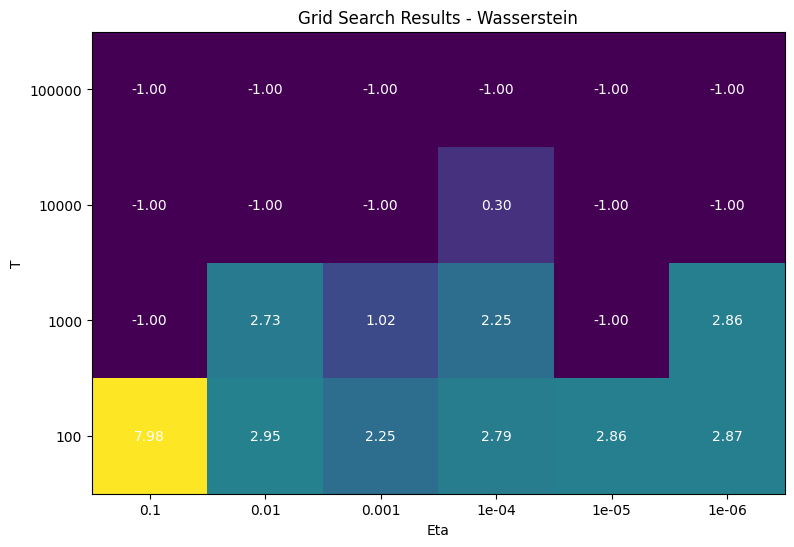

In [64]:
# Plot the grid
plt.figure(figsize=(10, 6))
plt.imshow(distances.T, cmap='viridis', origin='lower')

# Add color bar
# cbar = plt.colorbar()
# cbar.set_label('Wasserstein Distance')

# Add text annotations for each cell
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        plt.text(i, j, f'{distances[i, j]:.2f}', ha='center', va='center', color='white')

# Set x and y axis labels and ticks
plt.xticks(np.arange(grid_x.shape[0]), etas)
plt.yticks(np.arange(grid_x.shape[1]), Ts)
plt.xlabel('Eta')
plt.ylabel('T')

plt.title('Grid Search Results - Wasserstein')
plt.grid(False)
plt.show()

In [65]:
# Check if results are robust

T = 10**4
eta = 1e-4

means_check = []
stds_check = []
distances_check = []

for i in range(20):
    key, subkey = random.split(random.PRNGKey(1000 * i))
    x0 = 3. + 0.5 * random.normal(key, (N, d))
    x, xs = sgldr(x0, logp, T=T, eta=eta)
    means_check.append(x.mean())
    stds_check.append(x.std())
    if np.any(np.isnan(x)):
        distances_check.append(-1)
    else:
        distances_check.append(wasserstein_1d(x.squeeze(), x_gauss.squeeze(), p=1))

NaNs at iteration 111
NaNs at iteration 8638
NaNs at iteration 3454
NaNs at iteration 2277
NaNs at iteration 5295
NaNs at iteration 2575


<function matplotlib.pyplot.show(close=None, block=None)>

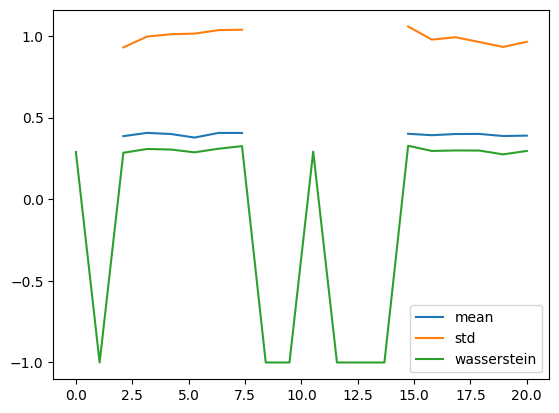

In [66]:
plt.plot(np.linspace(0, 20, 20), np.array(means_check))
plt.plot(np.linspace(0, 20, 20), np.array(stds_check))
plt.plot(np.linspace(0, 20, 20), np.array(distances_check))
plt.legend(['mean', 'std', 'wasserstein'])
plt.show

### Wasserstein distance for convergence monitoring

In [89]:
def svgd2(x0, logp, T=100, eta=0.1, tol=1e-3, p=1):
    
    x = x0
    g_logp = grad(logp)
    wass = []

    update_svgd = jit( lambda x : K(x) @ g_logp(x) + g_K(x).sum(0) ) 

    for i in range(T):
        x = x + eta * update_svgd(x)
        if np.any(np.isnan(x)):
            print(f'NaNs at iteration {i}')
            break
        w = wasserstein_1d(x.squeeze(), x_gauss.squeeze(), p=p)
        wass.append(w)
    
    return x, wass

In [90]:
x, wass = svgd2(x0, logp, T=1000, eta=0.01, p=1)

<function matplotlib.pyplot.show(close=None, block=None)>

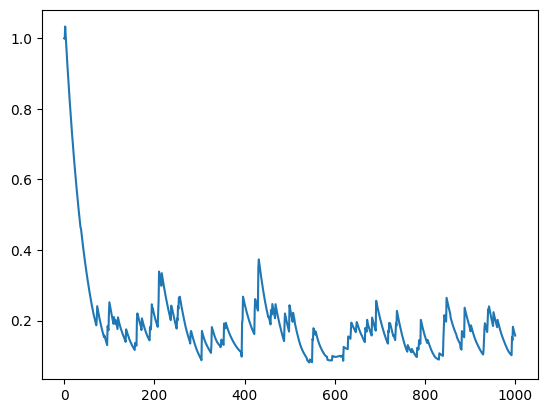

In [91]:
plt.plot(np.linspace(0, 1000, 1000), np.array(wass) / wass[0])
plt.show

In [92]:
def sgldr2(x0, logp, T=100, eta=0.1, p=p, key=key):
    
    x = x0
    g_logp = grad(logp)
    # xs = []
    wass = []

    update_sgldr = jit( lambda x, key : ( eta * (K(x) @ g_logp(x) + g_K(x).sum(0)) + \
                                         np.linalg.cholesky(2 * eta * K(x)) @ random.normal(key, (N, d)), random.split(key)[0] ) )

    for i in range(T):
        x_upd, key = update_sgldr(x, key)
        x = x + x_upd
        # xs.append(x)
        if np.any(np.isnan(x)):
            print(f'NaNs at iteration {i}')
            break
        w = wasserstein_1d(x.squeeze(), x_gauss.squeeze(), p=p)
        wass.append(w)
    
    return x, wass

In [98]:
x, wass = sgldr2(x0, logp, T=10**3, eta=1e-3, p=1, key=key)

<function matplotlib.pyplot.show(close=None, block=None)>

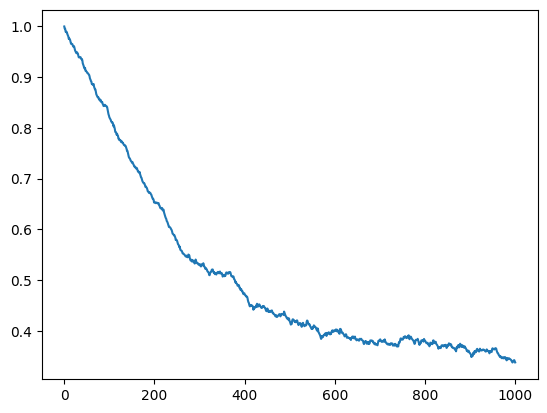

In [99]:
plt.plot(np.linspace(0, 10**3, 10**3), np.array(wass) / wass[0])
plt.show

In [ ]:
def sgd(x0, logp, T=100):
    
    x = x0
    g_logp = grad(logp)

    update_sgd = jit( lambda x : g_logp(x) ) 

    for i in range(T):
        x = x + eta * update_sgd(x)   
    return x

In [ ]:
x = sgd(x0, logp, T = 200)

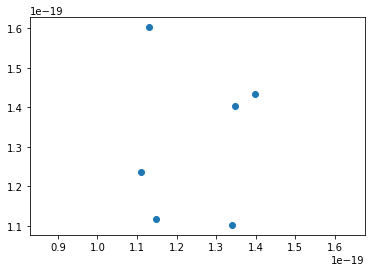

In [31]:
plt.plot(x[:,0], x[:,1], 'o')
plt.axis('equal');

In [32]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(1.280825e-19, dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32))

In [ ]:
def sgld(x0, logp, T=100, key = key):
    
    x = x0
    g_logp = grad(logp)
    xs = []

    update_sgld = jit( lambda x, key : ( (eta * g_logp(x)) + np.linalg.cholesky(2 * eta * np.eye(N)) @ random.normal(key, (N, d)), random.split(key)[0] ) )

    for i in range(T):
        x_upd, key = update_sgld(x, key)
        x = x + x_upd
        xs.append(x)
    return x, xs

In [ ]:
x, xs = sgld(x0, logp, T = 200)

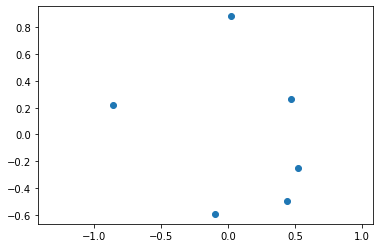

In [ ]:
xs = np.asarray(xs)
plt.plot(xs[-1,:,0], xs[-1, :,1], 'o')
plt.axis('equal');

In [ ]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(0.04436448, dtype=float32),
 DeviceArray(0.48139596, dtype=float32),
 DeviceArray(0.5093883, dtype=float32))

In [ ]:
def sgdm(x0, logp, T=100, alpha=0.5):
    
    x = x0
    g_logp = grad(logp)

    update_sgd = jit( lambda x : g_logp(x) ) 
    m = np.zeros_like(x)

    for i in range(T):
        m = alpha * m + eta * update_sgd(x)   
        x = x + m
    return x

In [ ]:
x = sgdm(x0, logp, T=200, alpha=0.5)

In [ ]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(8.837335e-31, dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32))

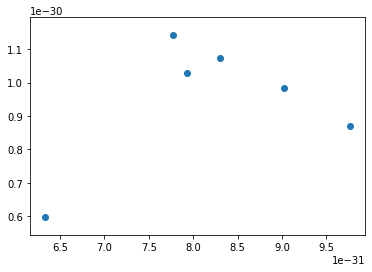

In [ ]:
plt.plot(x[:,0], x[:,1], 'o')
plt.axis('equal');

In [ ]:
def sgdmr(x0, logp, T=100, alpha=0.9):
    
    x = x0
    g_logp = grad(logp)

    update_sgdm1 = jit( lambda x, m : K(x) @ m + g_K(x).sum(0) ) 
    update_sgdm2 = jit( lambda x : K(x) @ g_logp(x) + g_K(x).sum(0) ) 
    m = np.zeros_like(x0)

    for i in range(T):
        x = x + eta * update_sgdm1(x, m)
        m = alpha * m + eta * update_sgdm2(x)
    return x

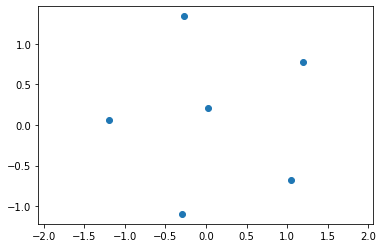

In [ ]:
x = sgdmr(x0, logp, T=50)
plt.plot(x[:,0], x[:,1], 'o')
plt.axis('equal');

In [ ]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(0.09437323, dtype=float32),
 DeviceArray(0.8222229, dtype=float32),
 DeviceArray(0.82081527, dtype=float32))

In [ ]:
x = svgd(x0, logp, T=50)
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(-3.1024218e-05, dtype=float32),
 DeviceArray(0.6126483, dtype=float32),
 DeviceArray(0.6195676, dtype=float32))